In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
100% 60.3M/60.3M [00:03<00:00, 23.3MB/s]
100% 60.3M/60.3M [00:03<00:00, 16.6MB/s]


In [3]:
!unzip /content/fer2013.zip -d  /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [4]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import imghdr
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report , roc_curve , auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers , models , regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model


In [5]:
os.makedirs('test_dir' , exist_ok= True)

In [6]:
project_name = 'Emotion_Det'

model_names = ['Custom_CNN_From_Scratch' ,
               'CUSTOM_CNN_WITH_AUG',
               'VGG16_TRANSFER_LEARNING' ,
               'RESNET50_TRANSFER_LEARNING']
base_dir = '/content/'
project_dir = os.path.join(base_dir , project_name)
os.makedirs(project_dir , exist_ok = True)

for model in model_names:
  model_dir = os.path.join(project_dir , model)
  os.makedirs(model_dir , exist_ok= True)


In [7]:
image_exts = ['jpeg' , 'jpg' , 'png']

data_dir = '/content/train'

for root , dirs , files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root , file)
    try:
      file_type = imghdr.what(file_path)
      if file_type not in image_exts:
        print(file_path)
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)
    except Exception as e :
      print( file_path , e)
      os.remove(file_path)


In [8]:
def count_files_in_dir(directory_path , set_name):
  counts = {}
  for items in os.listdir(directory_path):
    item_path = os.path.join(directory_path , items)
    if(os.path.isdir(item_path)):
      counts[items] = len(os.listdir(item_path))

  df = pd.DataFrame(counts , index=[set_name])
  return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_dir(train_dir , 'train')
test_count = count_files_in_dir(test_dir , 'test')
print(train_count)
print(test_count)

       surprise  happy   sad  disgust  fear  angry  neutral
train      3171   7215  4830      436  4097   3995     4965
      surprise  happy   sad  disgust  fear  angry  neutral
test       831   1774  1247      111  1024    958     1233


<Axes: >

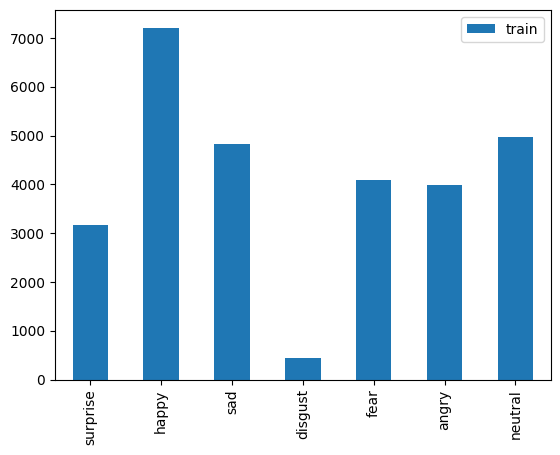

In [9]:
train_count.transpose().plot(kind = 'bar')

<Axes: >

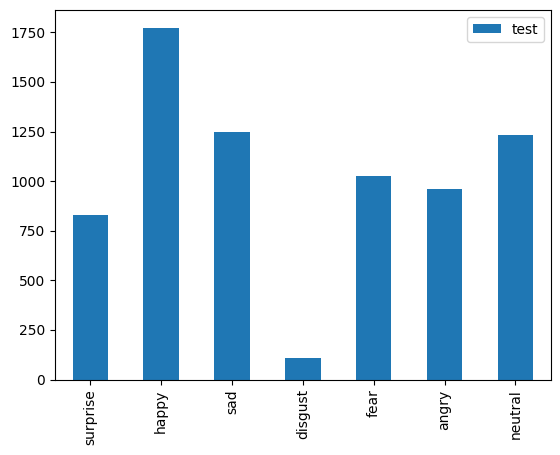

In [10]:
test_count.transpose().plot(kind = 'bar')

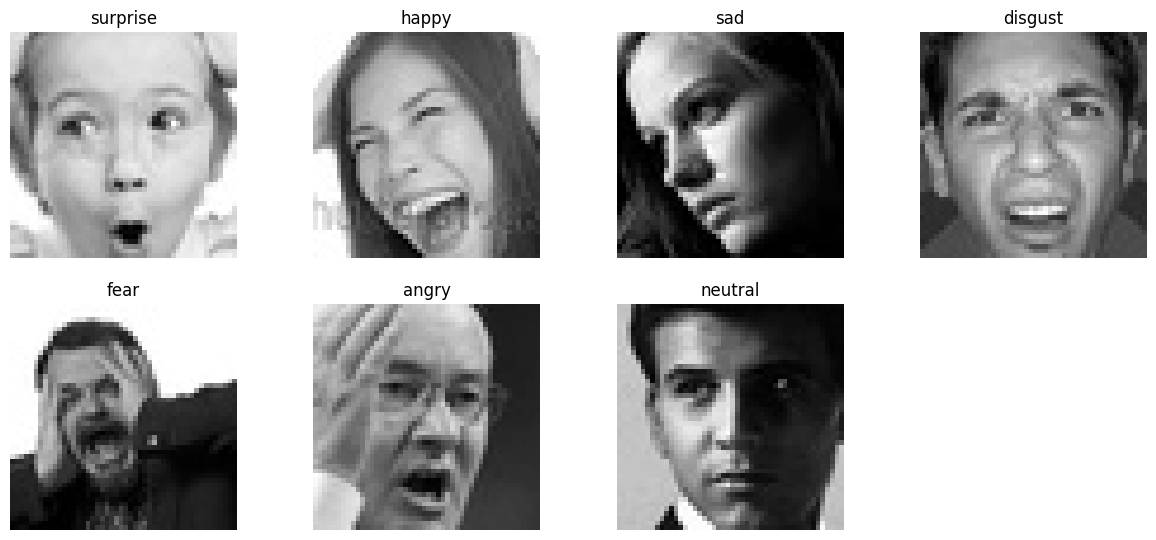

In [11]:
emotions = os.listdir(train_dir)
plt.figure(figsize = (15 , 10 ))

for i , emotion in enumerate(emotions , 1 ):
  folder = os.path.join(train_dir , emotion)
  img_path = os.path.join(folder , os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3 ,4 , i )
  plt.imshow(img , cmap = 'gray')
  plt.title(emotion)
  plt.axis('off')

In [12]:
def plt_random_images(directory_path , class_name , num_size = 9 ):
  image_filenames = os.listdir(directory_path)
  if len(image_filenames) < num_size:
    num_size = len(image_filenames)
  selected_image = random.sample(image_filenames , num_size)
  fig , axes = plt.subplots(3 ,3 , figsize = (5 ,5))
  axes = axes.ravel()
  for i, file in enumerate(selected_image):
    file_path = os.path.join(directory_path , file)
    img = load_img(file_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

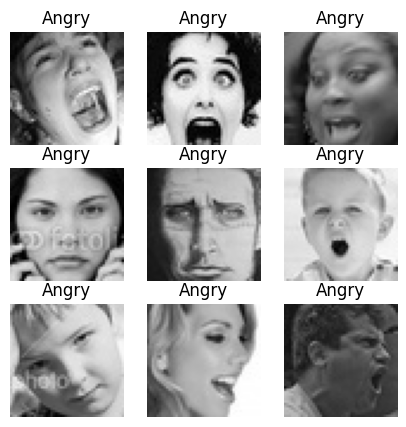

In [13]:
angry_dir = '/content/train/angry'
plt_random_images(angry_dir , 'Angry' )

In [14]:
image ='/content/train/disgust/Training_10371709.jpg'
image = cv2.imread(image)
if image is not None:
  print(image.shape)
else:
  print("premission denied")
# by default it is loading in color channel hence 3

(48, 48, 3)


In [15]:
image ='/content/train/disgust/Training_10371709.jpg'
image = cv2.imread(image ,  cv2.IMREAD_GRAYSCALE)
if image is not None:
  print(image.shape )
else:
  print("premission denied")

(48, 48)


# Model one from sctratch

In [16]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'


In [17]:
img_width , img_height = 48 , 48
batch_size = 64
epochs = 10
num_classes = 7

In [18]:
data_generator = ImageDataGenerator(rescale = 1./255 , validation_split = 0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir ,
    target_size = (img_height , img_width) ,
    batch_size = batch_size ,
    class_mode = 'categorical',
    color_mode = 'grayscale' ,
    subset = 'training'
)
validation_generator = data_generator.flow_from_directory(
    train_data_dir ,
    target_size = (img_height , img_width) ,
    batch_size = batch_size ,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)
test_generator = data_generator.flow_from_directory(
    test_data_dir ,
    target_size = (img_height , img_width) ,
    batch_size = batch_size ,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
train_class_label = train_generator.class_indices
validation_class_label = validation_generator.class_indices
test_class_label = test_generator.class_indices
print(train_class_label)
print(validation_class_label)
print(test_class_label)



{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [20]:
# Initialising the CNN
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [22]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy' ,
              metrics= ['accuracy'])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

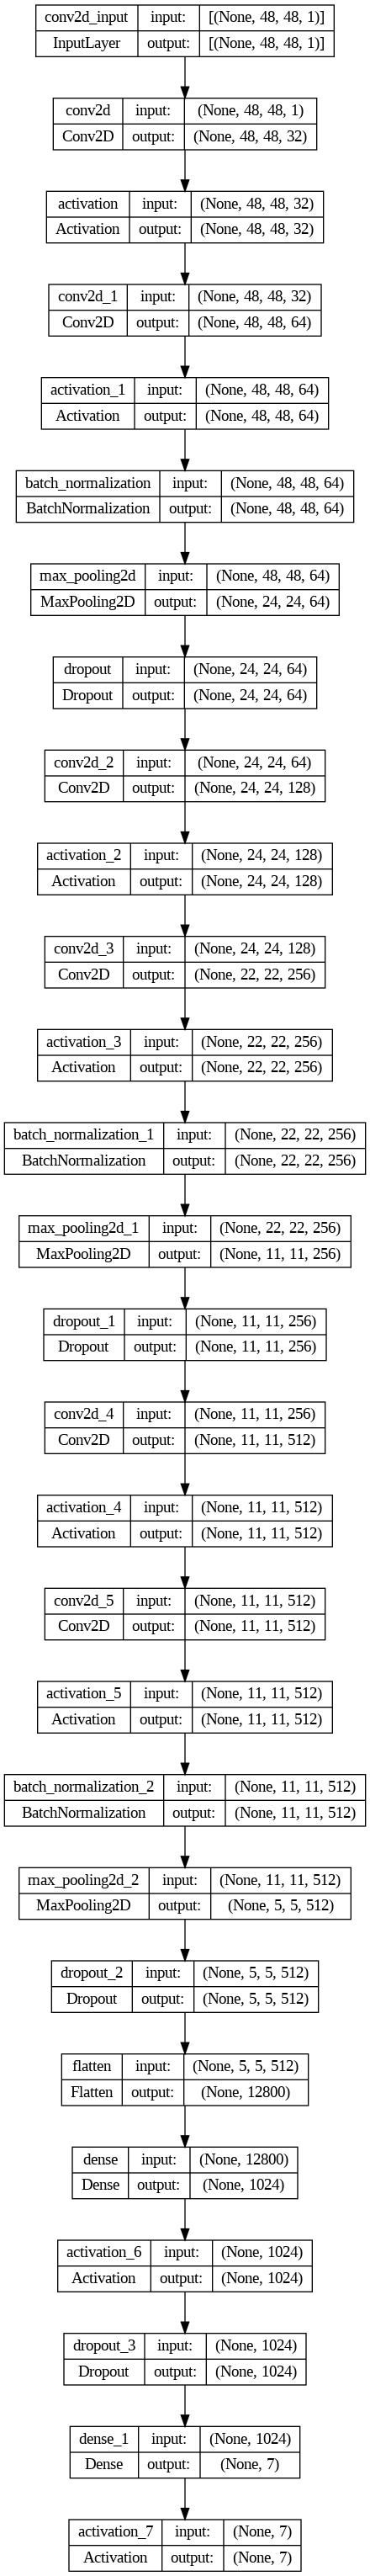

In [24]:
plot_model(model , to_file = '/content/Emotion_Det/Custom_CNN_From_Scratch/model.png' , show_shapes = True , show_layer_names= True)

In [25]:
cnn_path = '/content/Emotion_Det/Custom_CNN_From_Scratch'
name = 'Custom_CNN_Model.keras'
chk_path = os.path.join(cnn_path , name)
chk_path


'/content/Emotion_Det/Custom_CNN_From_Scratch/Custom_CNN_Model.keras'

In [26]:
checkpoint = ModelCheckpoint(filepath = chk_path , save_best_only = True , verbose = 1 , mode = 'min' , monitor = 'val_loss')

In [27]:
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0 , patience = 3  , verbose = 1 , restore_best_weights = True )

In [28]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss' , factor = 0.2  , patience = 6 , verbose = 1 , min_delta = 0.0001)

In [29]:
csv_logger = CSVLogger(os.path.join(cnn_path , 'training.log'))
callbacks = [checkpoint , earlystop , reduce_lr , csv_logger]

In [30]:
train_generator.samples

22968

In [31]:
train_step = train_generator.samples// train_generator.batch_size +1
val_steps = validation_generator.samples//validation_generator.batch_size +1
test_steps = test_generator.samples // test_generator.batch_size + 1

In [32]:
history = model.fit(
    train_generator , steps_per_epoch = int(train_step),
    epochs = 10 ,
    validation_data = validation_generator ,
    validation_steps = val_steps ,
    callbacks = callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4500 - accuracy: 0.2718
Epoch 1: val_loss improved from inf to 12.56961, saving model to /content/Emotion_Det/Custom_CNN_From_Scratch/Custom_CNN_Model.keras
359/359 [==============================] - 41s 86ms/step - loss: 12.4500 - accuracy: 0.2718 - val_loss: 12.5696 - val_accuracy: 0.1791 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.2710 - accuracy: 0.3526
Epoch 2: val_loss improved from 12.56961 to 9.58784, saving model to /content/Emotion_Det/Custom_CNN_From_Scratch/Custom_CNN_Model.keras
359/359 [==============================] - 25s 70ms/step - loss: 10.2710 - accuracy: 0.3526 - val_loss: 9.5878 - val_accuracy: 0.3731 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.3064 - accuracy: 0.3961
Epoch 3: val_loss improved from 9.58784 to 7.52224, saving model to /content/Emotion_Det/Custom_CNN_From_Scratch/Custom_CNN_Model.keras
3

In [33]:
def plot_training_hsitory(history):
  acc = history.history['accuracy' ]
  val_acc = history.history['val_accuracy' ]
  loss= history.history[ 'loss' ]
  val_loss= history.history['val_loss']
  epoch_ranges = range(len(acc))
  plt.figure(figsize= (20 ,5 ))
  plt.subplot(1 , 2 , 1)
  plt.plot(epoch_ranges , acc , label = 'Training accuracy')
  plt.plot(epoch_ranges , val_acc , label = 'validation accuracy ')
  plt.legend(loc = 'lower right')
  plt.title('training and accuracy data ')

  plt.subplot(1 , 2, 2 )
  plt.plot(epoch_ranges , loss , label = 'Training loss')
  plt.plot(epoch_ranges , val_loss , label = 'validation loss')
  plt.legend(loc='upper right')
  plt.title('Training and accuracy loss')

  plt.show()

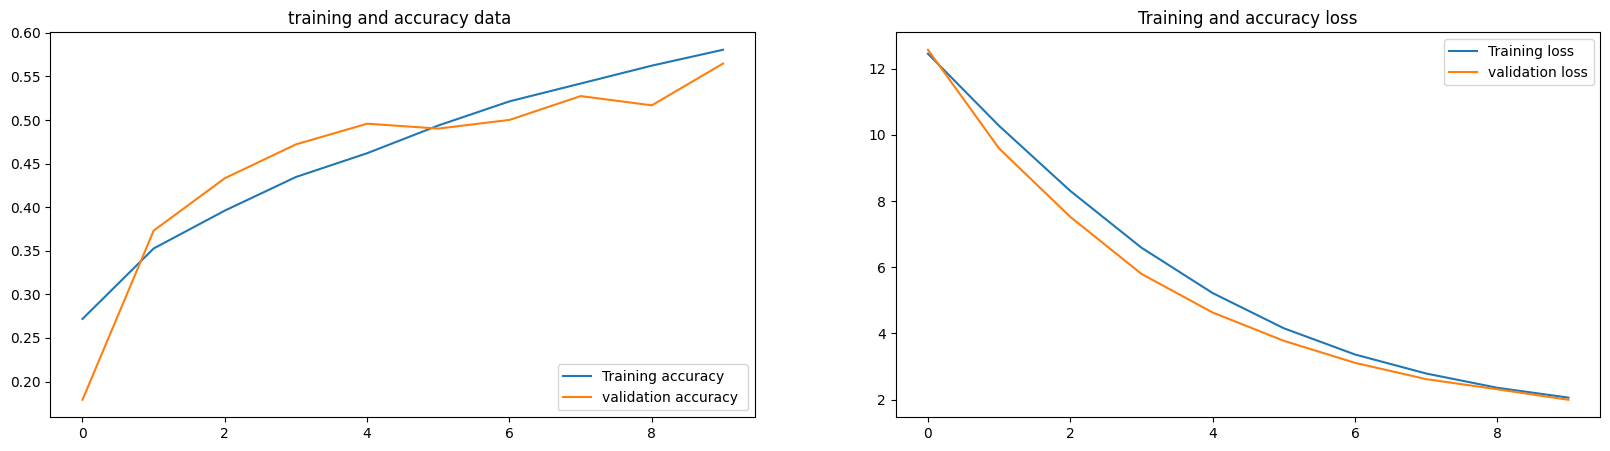

In [34]:
plot_training_hsitory(history)


In [35]:
train_loss , train_Accuracy = model.evaluate(train_generator)
test_loss , test_accuracy = model.evaluate(test_generator)
print(train_loss , train_Accuracy)
print(test_loss , test_accuracy)

113/113 [==============================] - 3s 27ms/step - loss: 1.9865 - accuracy: 0.5716
1.8049172163009644 0.6546934843063354
1.9865002632141113 0.5716077089309692


113/113 [==============================] - 3s 21ms/step


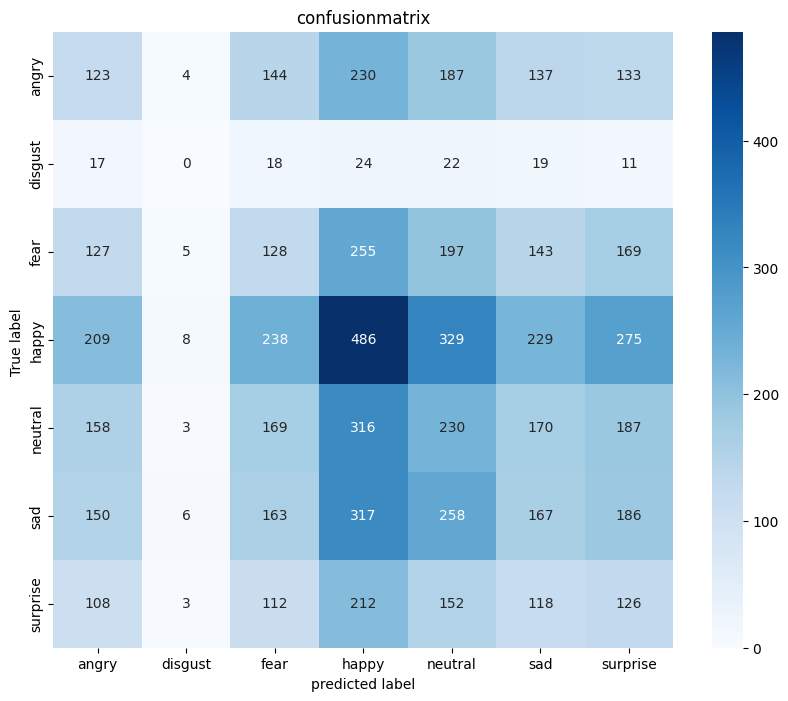

In [36]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator , steps = int(np.ceil(test_generator.samples/test_generator.batch_size))), axis = 1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)
plt.figure(figsize = (10 ,8))
sns.heatmap(cm , annot = True , fmt = "d" , cmap = "Blues" , xticklabels = class_labels , yticklabels = class_labels)
plt.title("confusionmatrix")
plt.ylabel("True label ")
plt.xlabel("predicted label")
plt.show()

In [37]:
report = classification_report(true_classes , predicted_classes , target_names= class_labels , zero_division = 0)
print(report)

              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.12      0.13      1024
       happy       0.26      0.27      0.27      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.17      0.13      0.15      1247
    surprise       0.12      0.15      0.13       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



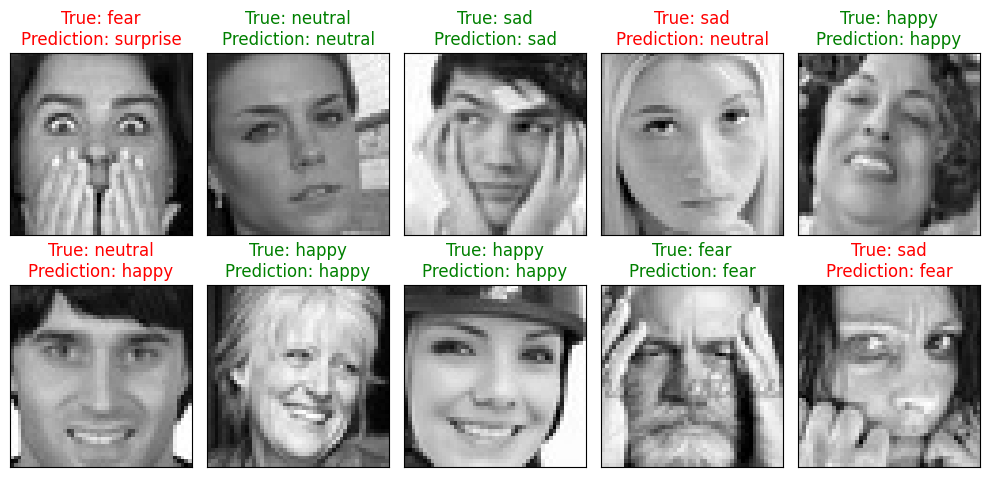

In [38]:

emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
batch_size = test_generator.batch_size
random_batch = np.random.randint(0, len(test_generator) - 1)
random_img_indexes = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    random_img = test_generator[random_batch][0][random_img_indexes[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_indexes[i]], axis=0)
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]

    ax.imshow(random_img.squeeze(), cmap='gray')

    color = 'green' if emotions[random_img_label] == emotions[model_prediction] else 'red'
    ax.set_title(f"True: {emotions[random_img_label]}\nPrediction: {emotions[model_prediction]}", color=color)

plt.tight_layout()
plt.show()


# AUC ROC PLOT

In [39]:
true_labels = test_generator.classes
preds = model.predict(test_generator , steps = len(test_generator))
pred_labels = np.argmax(preds , axis =1 )
classes = list(test_generator.class_indices.keys())

113/113 [==============================] - 2s 21ms/step


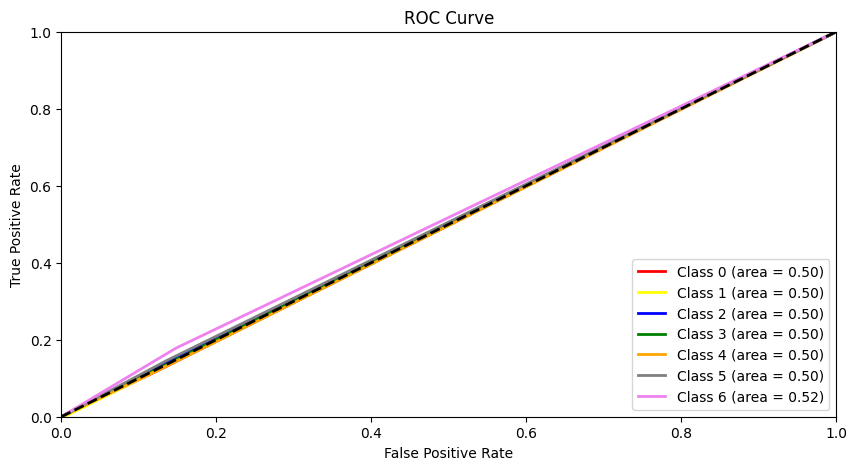

In [40]:

# One-hot encode the labels
y_encoded = pd.get_dummies(true_labels).astype(int).values
pred_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()

# Replace 7 with the number of classes
num_classes = y_encoded.shape[1]
classes = [f'Class {i}' for i in range(num_classes)]

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:, i], pred_encoded[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 5))
colors = ['red', 'yellow', 'blue', 'green', 'orange', 'grey', 'violet']

for i, color in enumerate(colors[:num_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [41]:
model.save("Custom_CNN_model.keras")

# using image augmentation

In [42]:
train_data_dir = '/content/train'
test_data_dir ='/content/test'

img_width = 48
img_height = 48
batch_size = 64
epochs = 10
num_classes = 7



In [43]:
data_generator = ImageDataGenerator(rescale = 1./255 ,
                                    rotation_range= 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2 ,
                                    shear_range = 0.2 ,
                                    zoom_range = 0.2 ,
                                    horizontal_flip =True,
                                    fill_mode = 'nearest',
                                    validation_split = 0.2
                                   )

train_generator = data_generator.flow_from_directory(train_data_dir ,
                                                     target_size = ( img_width , img_height) ,
                                                     batch_size = batch_size ,
                                                     class_mode = 'categorical' ,
                                                     color_mode = 'grayscale' ,
                                                     subset = 'training' )
test_data_generator = ImageDataGenerator(rescale = 1./255)

validation_generator = data_generator.flow_from_directory(train_data_dir ,
                                                          target_size = (img_width , img_height ) ,
                                                          batch_size= batch_size ,
                                                          class_mode = 'categorical' ,
                                                          color_mode = 'grayscale' ,
                                                          subset ='validation')
test_generator = test_data_generator.flow_from_directory(test_data_dir ,
                                                         target_size = (img_width , img_height) ,
                                                         batch_size = batch_size ,
                                                         class_mode = 'categorical' ,
                                                         color_mode = 'grayscale' )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


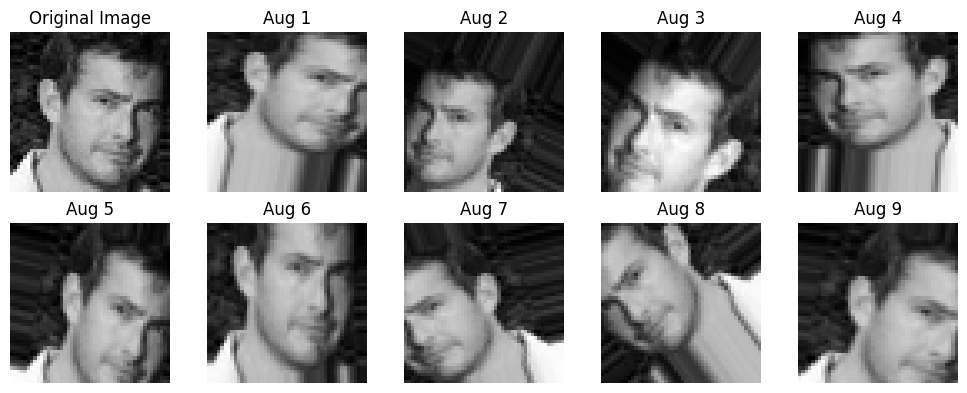

In [44]:

# Image path and dimensions
img_path = '/content/train/angry/Training_10120469.jpg'

img = load_img(img_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
axes = axes.flatten()

axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i in range(1, 10):
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]
    axes[i].imshow(aug_img[:, :, 0], cmap='gray')
    axes[i].set_title(f'Aug {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [45]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/Emotion_Det/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.5520 - accuracy: 0.2187
Epoch 1: val_loss improved from inf to 12.43003, saving model to /content/Emotion_Det/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 37s 86ms/step - loss: 12.5520 - accuracy: 0.2187 - val_loss: 12.4300 - val_accuracy: 0.1761 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.3756 - accuracy: 0.2421
Epoch 2: val_loss improved from 12.43003 to 10.35853, saving model to /content/Emotion_Det/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 32s 88ms/step - loss: 10.3756 - accuracy: 0.2421 - val_loss: 10.3585 - val_accuracy: 0.2163 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.3010 - accuracy: 0.2453
Epoch 3: val_loss improved from 10.35853 to 7.88606, saving model to /content/Emotion_Det/Custom_CNN_W

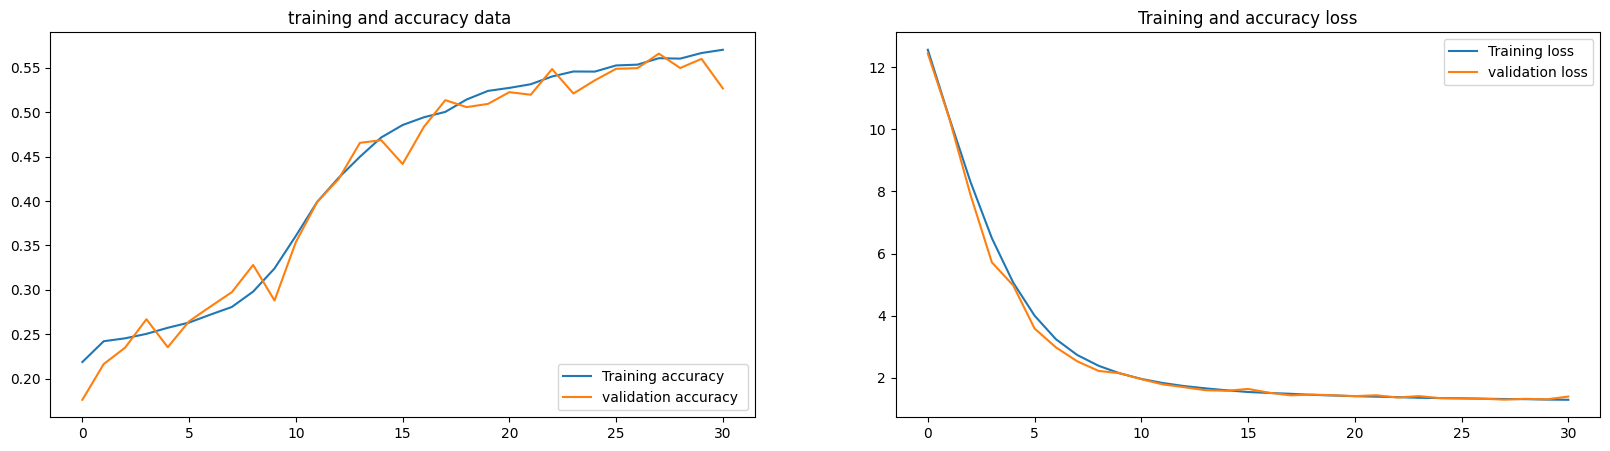

In [46]:
plot_training_hsitory(history)

In [47]:
train_loss , train_accu = model.evaluate(train_generator)
test_loss , test_accu = model.evaluate(test_generator)

print(train_loss , test_loss)
print(train_accu*100 , test_accu*100)

113/113 [==============================] - 3s 23ms/step - loss: 1.2273 - accuracy: 0.5864
1.247645616531372 1.2272799015045166
58.651167154312134 58.637505769729614


113/113 [==============================] - 3s 24ms/step


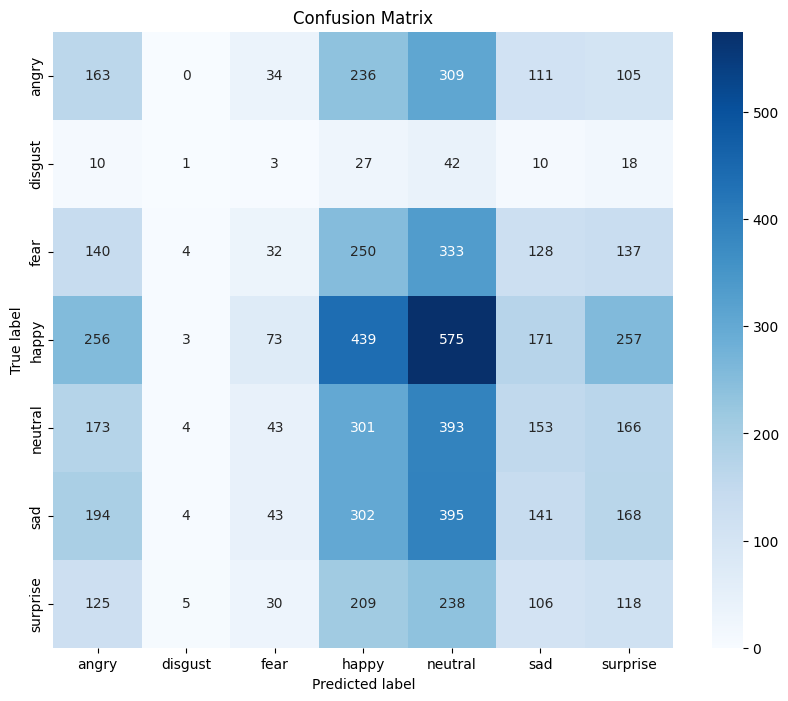

In [48]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [49]:
report = classification_report(true_classes , predicted_classes , target_names = class_labels , zero_division  = 0)
print(report)

              precision    recall  f1-score   support

       angry       0.15      0.17      0.16       958
     disgust       0.05      0.01      0.02       111
        fear       0.12      0.03      0.05      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.32      0.22      1233
         sad       0.17      0.11      0.14      1247
    surprise       0.12      0.14      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.17      0.18      0.17      7178



In [50]:
model.save("custom_CNN_with_AUG.keras")

# training with VGG16

In [51]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'



img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [52]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [53]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [54]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [55]:
# File path for the model checkpoint
cnn_path = '/content/Emotion_Det/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [56]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=5,
                    callbacks = callbacks)

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 1.5845 - accuracy: 0.3828
Epoch 1: val_loss improved from inf to 1.34924, saving model to /content/Emotion_Det/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 461s 995ms/step - loss: 1.5845 - accuracy: 0.3828 - val_loss: 1.3492 - val_accuracy: 0.4911 - lr: 1.0000e-04
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 1.3735 - accuracy: 0.4717
Epoch 2: val_loss improved from 1.34924 to 1.30834, saving model to /content/Emotion_Det/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 429s 956ms/step - loss: 1.3735 - accuracy: 0.4717 - val_loss: 1.3083 - val_accuracy: 0.5029 - lr: 1.0000e-04
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 1.2873 - accuracy: 0.5091
Epoch 3: val_loss improved from 1.30834 to 1.23242, saving model to /content/Emotion_Det/VGG16_Transfer_Learning/VGG16_Transfer_L

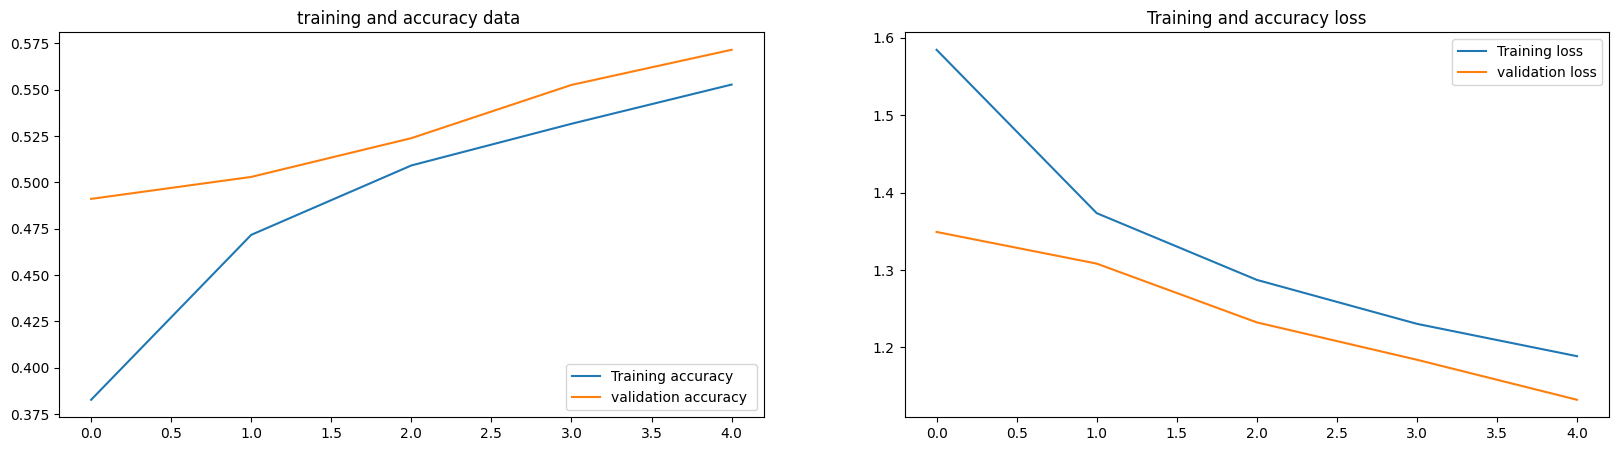

In [57]:
plot_training_hsitory(history)

In [58]:
train_loss , train_accuracy = model.evaluate(train_generator)
test_loss , test_accuracy = model.evaluate(test_generator)
print(train_loss , test_loss )
print(train_accuracy*100 , test_accuracy*100)

113/113 [==============================] - 28s 251ms/step - loss: 1.1325 - accuracy: 0.5715
1.118447184562683 1.1324819326400757
57.97833204269409 57.14683532714844


112/112 [==============================] - 28s 250ms/step


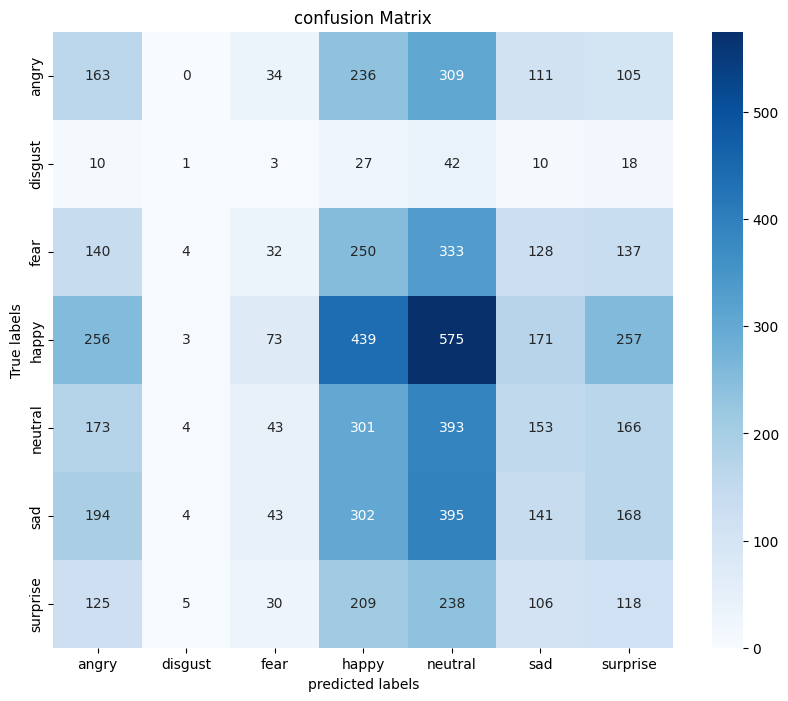

In [61]:
true_classes = test_generator.classes
predicted_class = np.argmax(model.predict(test_generator , steps = int(np.ceil(test_generator.samples // test_generator.batch_size))) ,axis = 1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

plt.figure(figsize = (10 ,8))
sns.heatmap(cm , annot = True , fmt ="d" , cmap = "Blues" , xticklabels = class_labels , yticklabels = class_labels)
plt.title('confusion Matrix')
plt.ylabel('True labels')
plt.xlabel('predicted labels')
plt.show()

In [62]:
report = classification_report(true_classes , predicted_classes ,target_names = class_labels , zero_division = 0)
print(report)

              precision    recall  f1-score   support

       angry       0.15      0.17      0.16       958
     disgust       0.05      0.01      0.02       111
        fear       0.12      0.03      0.05      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.32      0.22      1233
         sad       0.17      0.11      0.14      1247
    surprise       0.12      0.14      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.17      0.18      0.17      7178



In [63]:
model.save('transferlearning_vgg16.keras')

# Transfer learning RESNET50

In [65]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

img_width , img_height = 224 , 224
batch_size = 64
epcohs = 10
num_classes = 7

data_generator = ImageDataGenerator(rescale = 1./255 , rotation_range = 10 , zoom_range = 0.2 , width_shift_range = 0.1 , height_shift_range = 0.1 ,
                                    horizontal_flip = True , fill_mode = 'nearest')

test_preprocessor = ImageDataGenerator(rescale = 1./255 )

train_generator = data_generator.flow_from_directory(train_data_dir , target_size = (img_width , img_height) , batch_size = batch_size ,
                                                     class_mode = 'categorical' , color_mode = 'rgb' ,subset = 'training' , shuffle = True)
test_generator = test_preprocessor.flow_from_directory(test_data_dir  , target_size = (img_width , img_height) , batch_size = batch_size ,
                                                       class_mode = 'categorical' , color_mode = 'rgb')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [66]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(class_weight = 'balanced' ,
                                     classes = np.unique(classes) ,
                                     y = classes)

class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)


{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [68]:
resnet50 = tf.keras.applications.ResNet50V2(input_shape= (224 , 224, 3) ,
                                           include_top =False ,
                                           weights = 'imagenet')

94668760/94668760 [==============================] - 6s 0us/step


In [69]:
resnet50.trainable = True

for layer in resnet50.layers[:-50]:
  layers.trainable = False

In [72]:
def Create_res50():
  model = Sequential([resnet50 , Dropout(0.25) , BatchNormalization() , Flatten() , Dense(64 , activation = 'relu') , BatchNormalization(),
                      Dropout(0.25) , Dense(7 , activation = 'softmax' )])
  return model

In [73]:
model = Create_res50()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [75]:
model.compile(optimizer = optimizers.Adam()  , loss = 'categorical_crossentropy' , metrics= ['accuracy'])

In [76]:
cnn_path = '/content/Emotion_Det/RESNET50_TRANSFER_LEARNING'
name = 'transferlearning_with_resnet50.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=7,
                              verbose=1,
                              restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1)
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

callbacks = [checkpoint, earlystopping, reduce_lr, csv_logger]

train_steps = train_generator.samples // train_generator.batch_size + 1
test_steps = test_generator.samples // test_generator.batch_size + 1

In [78]:
history = model.fit(train_generator , steps_per_epoch = train_steps , validation_data = test_generator , validation_steps = test_steps , class_weight = class_weights_dict  ,callbacks = callbacks)

449/449 [==============================] - ETA: 0s - loss: 2.0580 - accuracy: 0.1766
Epoch 1: val_loss improved from inf to 310.59482, saving model to /content/Emotion_Det/RESNET50_TRANSFER_LEARNING/transferlearning_with_resnet50.keras
449/449 [==============================] - 544s 1s/step - loss: 2.0580 - accuracy: 0.1766 - val_loss: 310.5948 - val_accuracy: 0.1877 - lr: 0.0010


In [79]:
model.save('resnet50.keras')

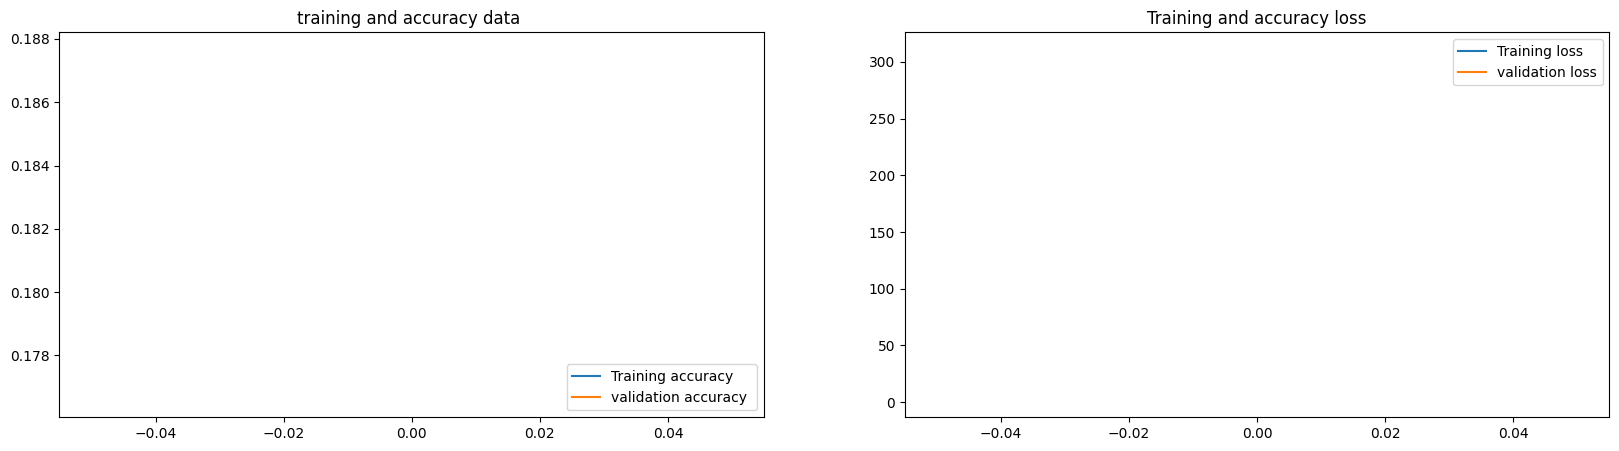

In [80]:
plot_training_hsitory(history)

In [ ]:
train_loss , train_accu = model.evaluate(train_generator)
test_loss , test_accu = model.evaluate(test_generator)

print(train_loss , test_loss)
print(train_accu*100 , test_accu*100)

 40/449 [=>............................] - ETA: 5:36 - loss: 466.1465 - accuracy: 0.1711

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator , steps = np.ceil(test_generator.samples//test_generator.batch_size)) , axis =1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

plt.figure(figsize =(10 , 8))
sns.heatmap(cm , annot = True , fmt = "d" , cmap = "Blues" , xticklabels = class_labels , yticklabels = class_labels)
plt.title('confusion_matrix')
plt.ylabel('true classes')
plt.xlabel('predicted classes')
plt.show()

In [ ]:
report = classification_report(true_classes , predicted_classes , target_names = class_labels , zero_division  = 0)
print(report)

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator , steps = len(test_generator))
pred_labels = np.argmax(preds , axis =1 )
classes = list(test_generator.class_indices.keys())

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
pred_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()

# Replace 7 with the number of classes
num_classes = y_encoded.shape[1]
classes = [f'Class {i}' for i in range(num_classes)]

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:, i], pred_encoded[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 5))
colors = ['red', 'yellow', 'blue', 'green', 'orange', 'grey', 'violet']

for i, color in enumerate(colors[:num_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!cp /content/Emotion_Det /content/drive/MyDrive/

In [ ]:
model.save()

In [ ]:
!pip3 install gradio

In [ ]:
import gradio as gr
model = tf.keras.models.load_model('transferlearning_resnet50.keras')
emotion_labels = {'angry' : 0, 'disgust' : 1, 'fear' : 2, 'happy' : 3, 'neutral' : 4, 'sad' : 5 , 'surprise' : 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}

def prepare_image(img_pil):
  img = img_pil.resize((224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /=  255.0
  return img_array

def prediction_emotion(image):
  processed_img = prepare_image(image)
  prediction = model.predict(processed_img)
  predicted_emotion = index_to_emotion.get(predicted_class[0])
  return predicted_emotion

interface = gr.Interface(fn=prediction_emotion, inputs=gr.inputs.Image(type="pil"), outputs="text" , title = "Emotion Detection" ,
                         description = "upload the image to get the results")
interface.launch()
